<a href="https://colab.research.google.com/github/juliasalto/proyectodatalab/blob/main/an%C3%A1lisis_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este hito del proyecto busco identificar las palabras más utilizadas en las reseñas de valoraciones, y analizar (de manera superficial) el sentimiento de cada una de ellas.

In [1]:
!pip install textblob
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files
from google.colab import auth
from google.cloud import bigquery
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
import warnings
from warnings import filterwarnings
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
auth.authenticate_user()

project_id = 'saltoproyecto3'
client = bigquery.Client(project=project_id)

query = """
SELECT *
FROM `saltoproyecto4.datalab.review_split`
"""

query_job = client.query(query)

df = query_job.to_dataframe()

df.head()

,user_id,user_name,review_id,review_title,review_content,img_link,product_link,product_id,rating,rating_count,mismatch,f0_
0,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...,B0BQRJ3C47,5,<NA>,False,5.0
1,AEU7DVFEL43XZ6T4D572W2ZLBRKQ,Yogita g.,R2WHW4PEF14WOD,Best Product,Must buy best Fabulous product I recommend this👍👍,None,None,B0BR4F878Q,4.8,53803,False,4.8
2,AGWOH7CFDMUVW52NMZWQBKBNNQOA,Amazon Customer,R2DCCZWUGI0O0K,It’s expansive but it works well upto 800sqft ...,For small place it’s gud,None,None,B0BR4F878Q,4.8,53803,False,4.8
3,AGZN422FGG7JO3T5YY6IVUELOODA,Mimsy,R1FA1HH6VL1RAL,Great product,A great product. Works wonders on my vitrified...,None,None,B0BR4F878Q,4.8,53803,False,4.8
4,AGHT3K4KSG5MAQUSXRDT5VNB73GA,Manidipa Sengupta,R1OO2ED6615EX1,Bad quality,The heating capacity is zero .Moreover i have ...,None,None,B0BPJBTB3F,2,2,False,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9042 entries, 0 to 9041
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9042 non-null   object 
 1   user_name       9041 non-null   object 
 2   review_id       9042 non-null   object 
 3   review_title    9030 non-null   object 
 4   review_content  8844 non-null   object 
 5   img_link        5535 non-null   object 
 6   product_link    5535 non-null   object 
 7   product_id      9042 non-null   object 
 8   rating          9042 non-null   object 
 9   rating_count    9040 non-null   Int64  
 10  mismatch        9042 non-null   boolean
 11  f0_             9042 non-null   float64
dtypes: Int64(1), boolean(1), float64(1), object(9)
memory usage: 803.7+ KB


In [5]:

df['rating'] = df['rating'].astype(float)


In [6]:
df['review_title'] = df['review_title'].str.lower()
df['review_title'] = df['review_title'].str.replace('[^\w\s]', '', regex=True)
df['review_title'] = df['review_title'].str.replace('\d', '', regex=True)

In [7]:
df['review_title']

,review_title
0,awesome product
1,best product
2,its expansive but it works well upto sqft area
3,great product
4,bad quality
...,...
9037,awesome product
9038,good quality
9039,product okay but no bill receive
9040,wrong reviews uploaded for this product


In [8]:
nltk.download('stopwords')
sw = stopwords.words('english')
sw

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
df['review_title'] = df['review_title'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [10]:
df['review_title']

,review_title
0,awesome product
1,best product
2,expansive works well upto sqft area
3,great product
4,bad quality
...,...
9037,awesome product
9038,good quality
9039,product okay bill receive
9040,wrong reviews uploaded product


In [11]:
temp_df = pd.Series(' '.join(df['review_title']).split()).value_counts()
temp_df

,count
good,2904
product,1874
nice,671
quality,546
money,420
...,...
stainless,1
witch,1
loading,1
fear,1


In [12]:
drops = temp_df[temp_df <= 1]
df['review_title'] = df['review_title'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['review_title']

,review_title
0,awesome product
1,best product
2,expansive works well upto sqft area
3,great product
4,bad quality
...,...
9037,awesome product
9038,good quality
9039,product okay bill receive
9040,wrong reviews product


In [13]:
temp_df_1 = pd.Series(' '.join(df['review_title']).split()).value_counts()
temp_df_1

,count
good,2904
product,1874
nice,671
quality,546
money,420
...,...
त,2
लए,2
यज,2
colors,2


In [14]:
#Tokenización
df["review_title"].apply(lambda x: TextBlob(x).words).head()

,review_title
0,"[awesome, product]"
1,"[best, product]"
2,"[expansive, works, well, upto, sqft, area]"
3,"[great, product]"
4,"[bad, quality]"


In [15]:
#Lematización
df['review_title'] = df['review_title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['review_title']

,review_title
0,awesome product
1,best product
2,expansive work well upto sqft area
3,great product
4,bad quality
...,...
9037,awesome product
9038,good quality
9039,product okay bill receive
9040,wrong review product


In [16]:
tf = df["review_title"].apply(lambda x: pd.Series(x.split(" ")).value_counts()).sum(axis=0).reset_index()



In [17]:
tf.columns = ['words', 'tf']
tf_sorted = tf.sort_values(by='tf', ascending=False)
tf_sorted


,words,tf
18,good,2908.0
1,product,1909.0
58,nice,671.0
11,quality,546.0
22,money,420.0
...,...,...
504,guess,2.0
506,quiet,2.0
1039,hd,2.0
510,steady,2.0


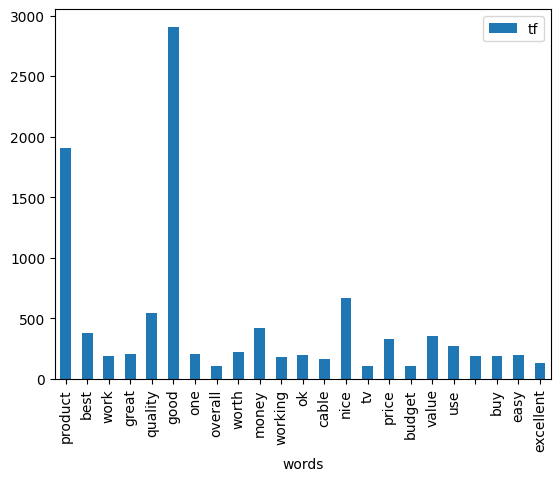

In [18]:
tf[tf["tf"] > 100].plot.bar(x="words", y="tf")
plt.show(block=True)

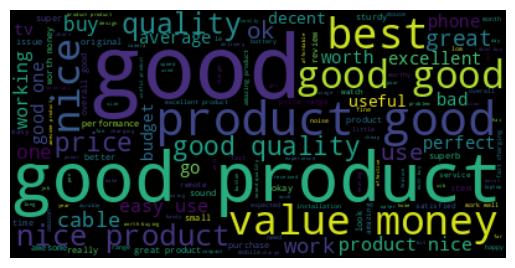

In [19]:
text = " ".join(i for i in df.review_title)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The product was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [ ]:
sia.polarity_scores("I liked this phone but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [ ]:
df["review_title"][0:10].apply(lambda x: sia.polarity_scores(x))

,review_title
0,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
1,"{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp..."
2,"{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'comp..."
3,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp..."
4,"{'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'comp..."
5,"{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'comp..."
6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp..."
8,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp..."
9,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."


In [ ]:
df["review_title"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

,review_title
0,0.6249
1,0.6369
2,0.2732
3,0.6249
4,-0.5423
5,0.5859
6,0.0000
7,0.4404
8,0.4404
9,0.4404


In [ ]:
df["polarity_score"] = df["review_title"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,user_id,user_name,review_id,review_title,review_content,img_link,product_link,product_id,rating,rating_count,mismatch,f0_,polarity_score
0,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,awesome product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...,B0BQRJ3C47,5,<NA>,False,5.0,0.6249
1,AEU7DVFEL43XZ6T4D572W2ZLBRKQ,Yogita g.,R2WHW4PEF14WOD,best product,Must buy best Fabulous product I recommend this👍👍,None,None,B0BR4F878Q,4.8,53803,False,4.8,0.6369
2,AGWOH7CFDMUVW52NMZWQBKBNNQOA,Amazon Customer,R2DCCZWUGI0O0K,expansive work well upto sqft area,For small place it’s gud,None,None,B0BR4F878Q,4.8,53803,False,4.8,0.2732
3,AGZN422FGG7JO3T5YY6IVUELOODA,Mimsy,R1FA1HH6VL1RAL,great product,A great product. Works wonders on my vitrified...,None,None,B0BR4F878Q,4.8,53803,False,4.8,0.6249
4,AGHT3K4KSG5MAQUSXRDT5VNB73GA,Manidipa Sengupta,R1OO2ED6615EX1,bad quality,The heating capacity is zero .Moreover i have ...,None,None,B0BPJBTB3F,2,2,False,2.0,-0.5423


In [ ]:
df["review_title"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

,review_title
0,pos
1,pos
2,pos
3,pos
4,neg
5,pos
6,neg
7,pos
8,pos
9,pos


In [ ]:
df["sentiment_label"] = df["review_title"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [ ]:
df["sentiment_label"].value_counts()


,count
sentiment_label,
pos,6382
neg,2660


In [ ]:
df.groupby("sentiment_label")["rating"].mean()

,rating
sentiment_label,
neg,4.043534
pos,4.102585


In [ ]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])


In [ ]:
df.head()

,user_id,user_name,review_id,review_title,review_content,img_link,product_link,product_id,rating,rating_count,mismatch,f0_,polarity_score,sentiment_label
0,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,awesome product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...,B0BQRJ3C47,5.0,<NA>,False,5.0,0.6249,1
1,AEU7DVFEL43XZ6T4D572W2ZLBRKQ,Yogita g.,R2WHW4PEF14WOD,best product,Must buy best Fabulous product I recommend this👍👍,None,None,B0BR4F878Q,4.8,53803,False,4.8,0.6369,1
2,AGWOH7CFDMUVW52NMZWQBKBNNQOA,Amazon Customer,R2DCCZWUGI0O0K,expansive work well upto sqft area,For small place it’s gud,None,None,B0BR4F878Q,4.8,53803,False,4.8,0.2732,1
3,AGZN422FGG7JO3T5YY6IVUELOODA,Mimsy,R1FA1HH6VL1RAL,great product,A great product. Works wonders on my vitrified...,None,None,B0BR4F878Q,4.8,53803,False,4.8,0.6249,1
4,AGHT3K4KSG5MAQUSXRDT5VNB73GA,Manidipa Sengupta,R1OO2ED6615EX1,bad quality,The heating capacity is zero .Moreover i have ...,None,None,B0BPJBTB3F,2.0,2,False,2.0,-0.5423,0


In [ ]:
df.to_csv('review_sentiment.csv', index=False)

# Descargar el archivo CSV en Google Colab (si estás usando Google Colab)
from google.colab import files
files.download('review_sentiment.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig = px.histogram(df, x="polarity_score")
fig.show()